In [31]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from itertools import permutations
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

import plotly.offline as py
import plotly.graph_objs as go

py.offline.init_notebook_mode(connected=True)

## Реалізація МНКО

In [32]:
def LSBM(X, y, s=None, sigma_estimation=1,
         verbose=False, deep_verbose=False, create_dataframe=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        if create_dataframe:
            w, H_inv, RSS, df = LSBM(X[:,:-1], y, s, sigma_estimation,
                                     verbose, deep_verbose, create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = LSBM(X[:,:-1], y, s, sigma_estimation,
                                 verbose, deep_verbose, create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS
        # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]    
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T @ alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T,           
                                (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))
        RSS_next = (RSS - nu.flatten() ** 2 * beta.flatten())[0]

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if create_dataframe:
            df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
        
    if verbose:
        print('===============================================')
        print('\tStep {}'.format(m))
        print('===============================================')
        if deep_verbose:
            print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
            print('eta_{}:\t\t{}'.format(m, eta))
            print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
            print('beta_{}:\t\t{}'.format(m, beta))
            print('gamma_{}:\t{}'.format(m, gamma))
            print('nu_{}:\t\t{}'.format(m, nu))
            print('===============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
        print('> RSS_{}: {}'.format(m, RSS_next))
    if create_dataframe:
        Cp = RSS_next + 2 * sigma_estimation * m
        n = y.shape[0]
        FPE = (n + m) / (n - m) * RSS_next
        df = df.append({'s': m, 'RSS': RSS_next, 'Cp': Cp, 'FPE': FPE},
                       ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next

# Модель Фергюльста

## Рівняння моделі
$ N'=μN(k-N) \enspace | \enspace N_0 $

## Різницеве рівняння
$ \Delta t = 1 $

$ N'(t) \approx N(t+1)-N(t) - \text{різниця вперед} $

$ N'(t) \approx N(t)-N(t-1) - \text{різниця назад} $

$ N'(t) \approx \frac{N(t+1)-N(t-1)}{2} - \text{центральна різниця} $

Розглядатимемо для різниці вперед:

$ \Rightarrow \left \{ \begin{array}{ll}
                        N(t+1)-N(t)=\mu N(t)[k-N(t)] \\
                        N(0) = N_0
                       \end{array} \right. $

$ \iff \left \{ \begin{array}{ll}
                    N(t+1)=(\mu k+1)N(t)-\mu N^2(t) \\
                    N(0) = N_0
                \end{array} \right. $
                
Отже, лінійна регресійна залежність виглядає таким чином:

$ \left \{ \begin{array}{ll}
                  y_i = \theta_1 x_{i1} +  \theta_2 x_{i2} + \xi_i\\
                  \theta_1 = \mu k+1\\
                  \theta_2 = -\mu\\
                  E\xi = 0_n;\enspace cov(\xi) = \sigma^2I_n
                \end{array}
              \right. $
              
$ \Rightarrow \left \{ \begin{array}{ll}  
                  \mu = -\theta_2 \\
                  k = (1 - \theta_1) / \theta_2
                \end{array} \right. $

In [60]:
def Verhulst_model_equation(N, t, μ, k):
    return μ * N * (k - N)

class VerhulstModelConfig(): 
    k = 100
    μ = 0.1
    N0 = 10
    t_start = 0
    t_end = 500
    num_samples = 50
    num_samples_grid = [10, 50, 100]
    C = 3
    C_grid = [0, 2, 5]

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.N = odeint(Verhulst_model_equation,
                        self.N0, self.t, (self.μ, self.k))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tμ = {}\n\t\t\t\
               k = {}\n\t\t\tN0 = {}\n'.format(self.μ, self.k, self.N0))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} \
               with discretization frequency {}\n'.format(self.t_start,
                                                          self.t_end,
                                                          self.h))
        
    def init_to_inter_params(self):
        w1 = self.μ * self.k + 1
        w2 = -self.μ
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        μ = - w2
        k = (1 - w1) / w2
        return μ, k
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['N(t)'] = self.N.flatten()
        self.df['N^2(t)'] = np.square(self.N.flatten())
        self.df['N(t+1)'] = np.array(self.df[['N(t)','N^2(t)']]) @ self.theta
        self.df['N(t+1)'] = np.round(self.df['N(t+1)'], self.C)
        self.X = np.array(self.df[['N(t)', 'N^2(t)']])
        self.y = np.array(self.df['N(t+1)'])
        
    def plot_3D(self):
        trace1 = go.Scatter3d(
            x=self.df['N(t)'],
            y=self.df['N^2(t)'],
            z=self.df['N(t+1)'],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            )
        )

        data = [trace1]
        layout = go.Layout(
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, filename='simple-3d-scatter')
        
    def run_single_LSBM(self, verbose=True, deep_verbose=True):
        print('Recurrent Least Squares Method')
        self.theta_pred = LSBM(self.X, self.y, verbose=verbose,
                               deep_verbose=deep_verbose)[0][:,0]
        self.μ_pred, self.k_pred = \
        self.inter_to_init_params(*self.theta_pred)
        print('=============================================')
        print('\nINTERMEDIATE PARAMETERS')
        print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*self.theta))
        print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*self.theta_pred))
        print('\nINITIAL PARAMETERS')
        print('True values:\tμ = {}\tk = {}'.format(self.μ, self.k))
        print('Estimates:\tμ* = {}\tk* = {}'.format(self.μ_pred, self.k_pred))
        plt.scatter(self.t, self.y)
        t_for_plot = np.linspace(self.t_start, self.t_end,
                                 num=self.num_samples * 10)
        plt.plot(t_for_plot, odeint(Verhulst_model_equation,
                                    self.N0, t_for_plot,
                                    (self.μ_pred, self.k_pred)), 'r')
        plt.show()
        
    def run_grid_LSBM(self, verbose=False):
        intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                          'θ_1', 'θ_1*',
                                                          'θ_2', 'θ_2*'])
        initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                     'μ', 'μ*', 'k', 'k*'])
        for C in self.C_grid:
            for num_samples in self.num_samples_grid: 
                self.recompile(C, num_samples)
                theta_pred = LSBM(self.X, self.y, verbose=False)[0][:,0]
                μ_pred, k_pred = self.inter_to_init_params(*theta_pred)
                intermediate_estimates_df = \
                intermediate_estimates_df.append({'C': self.C,
                                                  'num_samples': self.num_samples,
                                                  'θ_1': self.theta[0],
                                                  'θ_1*': theta_pred[0],
                                                  'θ_2': self.theta[1],
                                                  'θ_2*': theta_pred[1]},
                                                 ignore_index=True)
                initial_estimates_df = \
                initial_estimates_df.append({'C': self.C,
                                             'num_samples': self.num_samples,
                                             'μ': self.μ,
                                             'μ*': μ_pred,
                                             'k': self.k,
                                             'k*': k_pred},
                                             ignore_index=True)
                if verbose:
                    print('=============================================================')
                    print('C: {}\t num_samples: {}'.format(self.C,
                                                           self.num_samples))
                    print('\nINTERMEDIATE PARAMETERS')
                    print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = \
                    {:12.8}'.format(*theta_pred))
                    print('\nINITIAL PARAMETERS')
                    print('Estimates:\tμ* = {: 12.8}\tk* = \
                    {: 12.8}'.format(μ_pred, k_pred))

        return pd.concat([intermediate_estimates_df,
                          initial_estimates_df[['μ', 'μ*', 'k', 'k*']]],
                         axis=1)

## Генерування вибірки

Initial parameters:	μ = 0.1
			               k = 100
			N0 = 10

Noise generation: C = 3
Sample length: n = 50
Time starting from 0 to 500                with discretization frequency 10



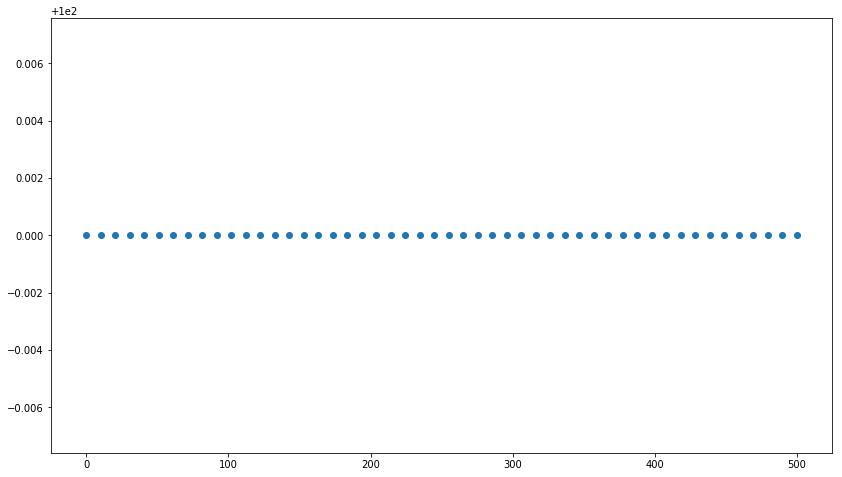

Intermediate parameters values: θ_1 = 11.0	θ_2 = -0.1
Regression model: y = (11.0) * x1 + (-0.1) * x2


,i,t,N(t),N^2(t),N(t+1)
0,1,0,10.0,100.0,100.0
1,2,10,100.0,10000.0,100.0
2,3,20,100.0,10000.0,100.0
3,4,30,100.0,10000.0,100.0
4,5,40,100.0,10000.0,100.0
5,6,51,100.0,10000.0,100.0
6,7,61,100.0,10000.0,100.0
7,8,71,100.0,10000.0,100.0
8,9,81,100.0,10000.0,100.0
9,10,91,100.0,10000.0,100.0


In [61]:
config = VerhulstModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

## Робота алгоритму МНКО

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		490100.00000000175
alpha_1:	[0]
beta_1:		490100.00000000175
gamma_1:	491000.0000000009
nu_1:		[1.00183636]
> θ_1: [1.00183636]
> H_1_inv:
[[2.04039992e-06]]
> RSS_1: 8098.347276066081
	Step 2
h_2:		[49001000.00000027]
eta_2:		4900010000.000035
alpha_2:	[99.9816364]
beta_2:		[[809834.72760582]]
gamma_2:	49010000.00000018
nu_2:		[[-0.1]]
> θ_2: [11.  -0.1]
> H_2_inv:
[[ 1.23457042e-02 -1.23459310e-04]
 [-1.23459310e-04  1.23481985e-06]]
> RSS_2: -8.20909917820245e-09

INTERMEDIATE PARAMETERS
True values:	θ_1 = 11.0	θ_2 = -0.1
Estimates:	θ_1* = 11.000000000009951	θ_2* = -0.10000000000009936

INITIAL PARAMETERS
True values:	μ = 0.1	k = 100
Estimates:	μ* = 0.10000000000009936	k* = 100.00000000000016


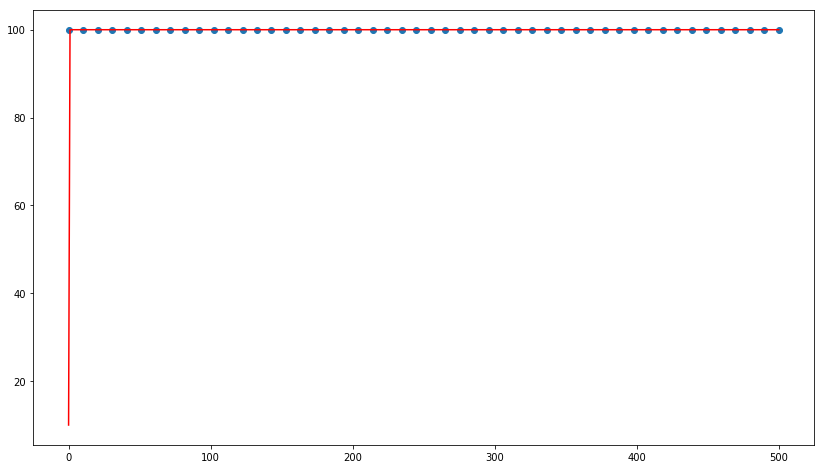

In [62]:
config.run_single_LSBM(verbose=True, deep_verbose=True)

## Таблиця залежності оцінок від рівня шуму

In [63]:
config.run_grid_LSBM(verbose=False)

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,μ,μ*,k,k*
0,0.0,10.0,11.0,11.0,-0.1,-0.1,0.1,0.1,100.0,100.0
1,0.0,50.0,11.0,11.0,-0.1,-0.1,0.1,0.1,100.0,100.0
2,0.0,100.0,11.0,11.0,-0.1,-0.1,0.1,0.1,100.0,100.0
3,2.0,10.0,11.0,11.0,-0.1,-0.1,0.1,0.1,100.0,100.0
4,2.0,50.0,11.0,11.0,-0.1,-0.1,0.1,0.1,100.0,100.0
5,2.0,100.0,11.0,11.0,-0.1,-0.1,0.1,0.1,100.0,100.0
6,5.0,10.0,11.0,11.0,-0.1,-0.1,0.1,0.1,100.0,100.0
7,5.0,50.0,11.0,11.0,-0.1,-0.1,0.1,0.1,100.0,100.0
8,5.0,100.0,11.0,11.0,-0.1,-0.1,0.1,0.1,100.0,100.0


---

# Рівняння згасаючих коливань

## Модель рівняння
$ x''+2\delta x'+\omega_0^2 x=0 $

## Різницеве рівняння
$ \Delta t = 1 $

$ x'(t) \approx x(t+1)-x(t) - \text{різниця вперед} $

$ x'(t) \approx x(t)-x(t-1) - \text{різниця назад} $

$ x'(t) \approx \frac{x(t+1)-x(t-1)}{2} - \text{центральна різниця} $

$ x''(t) \approx x(t+1)-2x(t)+x(t-1) $

Розглянемо для апроксимації різницею вперед:

$ \Rightarrow \left \{ \begin{array}{ll}
                          x(t+1)-2x(t)+x(t-1)+2\delta[x(t+1)-x(t)]+\omega_0^2 x(t)=0 \\
                          x(0) = x_0\\
                          x(1) = x(0) + x'(0) = x_0 + x'_0
                       \end{array} \right. $

$ \iff \left \{ \begin{array}{ll}
                    x(t+2)=\frac{2+2\delta-\omega_0^2}{1+2\delta}x(t+1)-\frac{1}{1+2\delta}x(t) \\
                    x(0) = x_0\\
                    x(1) = x_0 + x'_0
                 \end{array} \right. $

Отже, лінійна регресійна залежність виглядає таким чином:

$ \left \{ \begin{array}{ll}
                  y_i = \theta_1 x_{i1} +  \theta_2 x_{i2} + \xi_i\\
                  \theta_1 = \frac{2+2\delta-\omega_0^2}{1+2\delta}\\
                  \theta_2 = -\frac{1}{1+2\delta}\\
                  E\xi = 0_n;\enspace cov(\xi) = \sigma ^2I_n
                \end{array}
              \right. $

In [72]:
def Oscillation_model_equation(x, t, δ, ω0_sqr):
    #x_0' = x_1 = x'
    #x_1' = x'' = - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    return [x[1],  - 2 * δ * x[1] - ω0_sqr * x[0]]        

class OscillationModelConfig(): 
    δ = 0.1
    ω0_sqr = 1.
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 100
    num_samples = 500
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]

    def __init__(self, difference='forward'):
        self.difference = difference
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.x = odeint(Oscillation_model_equation,
                        np.array([self.x0, self.x00]),
                        self.t, (self.δ, self.ω0_sqr))
        self.x1 = self.x0 + self.x00
        self.x11 = self.x00
        self.x_1 = odeint(Oscillation_model_equation,
                          np.array([self.x1, self.x11]), self.t+1,
                          (self.δ, self.ω0_sqr))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tδ = {}\n\t\t\tω0^2 = {}\
              \n\t\t\tx0 = {}\n\t\t\tx00 = {}\n'.format(self.δ, self.ω0_sqr,
                                                        self.x0, self.x00))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} \
               with discretization frequency {}\n'.format(self.t_start,
                                                          self.t_end,
                                                          self.h))
        
    def init_to_inter_params(self):
        if self.difference == 'center':
            divider = 1 + self.δ
            w1 = (2 - self.ω0_sqr) / divider
            w2 = - (1 - self.δ) / divider
        elif self.difference == 'forward':
            divider = 1 + 2 * self.δ
            w1 = (2 + 2 * self.δ - self.ω0_sqr) / divider
            w2 = - 1 / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        if self.difference == 'center':
            δ = (1 + w2) / (1 - w2)
            ω0_sqr = (2 - 2 * w1 - 2 * w2) / (1 - w2)
        elif self.difference == 'forward':
            δ = - (1 / w2 + 1) / 2
            ω0_sqr = 1 - 1 / w2 + w1 / w2
        return δ, ω0_sqr
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['x(t)'] = self.x[:,0].flatten()
        self.df['x(t+1)'] = self.x_1[:,0].flatten()
        self.df['x(t+2)'] = np.array(self.df[['x(t)','x(t+1)']]) @ self.theta
        self.df['x(t+2)'] = np.round(self.df['x(t+2)'], self.C)
        self.X = np.array(self.df[['x(t)', 'x(t+1)']])
        self.y = np.array(self.df['x(t+2)'])
    
    def plot_3D(self):
        trace1 = go.Scatter3d(
            x=self.df['x(t)'],
            y=self.df['x(t+1)'],
            z=self.df['x(t+2)'],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            )
        )

        data = [trace1]
        layout = go.Layout(
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, filename='simple-3d-scatter')

    def run_single_LSBM(self, verbose=True, deep_verbose=False):
        print('Recurrent Least Squares Method')
        self.theta_pred = LSBM(self.X, self.y, verbose=verbose,
                               deep_verbose=deep_verbose)[0][:,0]
        self.δ_pred, self.ω0_sqr_pred = \
        self.inter_to_init_params(*self.theta_pred)
        print('=============================================')
        print('\nINTERMEDIATE PARAMETERS')
        print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*self.theta))
        print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*self.theta_pred))
        print('\nINITIAL PARAMETERS')
        print('True values:\tδ = {}\t\t\tω0^2 = {}'.format(self.δ,
                                                           self.ω0_sqr))
        print('Estimates:\tδ* = {}\tω0^2* = {}'.format(self.δ_pred,
                                                       self.ω0_sqr_pred))
        plt.scatter(self.t, self.y)
        t_for_plot = np.linspace(self.t_start, self.t_end,
                                 num=self.num_samples * 10)
        plt.plot(t_for_plot, odeint(Oscillation_model_equation, 
                                    np.array([self.x0, self.x00]),
                                    t_for_plot,
                                    (self.δ_pred,
                                     self.ω0_sqr_pred))[:,0], 'r')
        plt.show()
        
    def run_grid_LSBM(self, verbose=True):
        intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                          'θ_1', 'θ_1*',
                                                          'θ_2', 'θ_2*'])
        initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                     'δ', 'δ*',
                                                     'ω0_sqr', 'ω0_sqr*'])
        for C in self.C_grid:
            for num_samples in self.num_samples_grid: 
                self.recompile(C, num_samples)
                intermediate_estimates_df
                theta_pred = LSBM(self.X, self.y, verbose=False)[0][:,0]
                δ_pred, ω0_sqr_pred = self.inter_to_init_params(*theta_pred)
                intermediate_estimates_df = \
                intermediate_estimates_df.append({'C': self.C,
                                                  'num_samples': self.num_samples,
                                                  'θ_1': self.theta[0],
                                                  'θ_1*': theta_pred[0],
                                                  'θ_2': self.theta[1],
                                                  'θ_2*': theta_pred[1]},
                                                 ignore_index=True)
                initial_estimates_df = \
                initial_estimates_df.append({'C': self.C,
                                             'num_samples': self.num_samples,
                                             'δ': self.δ,
                                             'δ*': δ_pred,
                                             'ω0_sqr': self.ω0_sqr,
                                             'ω0_sqr*': ω0_sqr_pred},
                                             ignore_index=True)
                if verbose:
                    print('=============================================================')
                    print('C: {}\t num_samples: {}'.format(self.C,
                                                           self.num_samples))
                    print('\nINTERMEDIATE PARAMETERS')
                    print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = \
                    {:12.8}'.format(*theta_pred))
                    print('\nINITIAL PARAMETERS')
                    print('Estimates:\tδ* = {: 12.8}\tk* = \
                    {: 12.8}'.format(δ_pred, ω0_sqr_pred))

        return pd.concat([intermediate_estimates_df,
                          initial_estimates_df[['δ', 'δ*', \
                                                'ω0_sqr', 'ω0_sqr*']]],
                         axis=1)

## Генерування вибірки

Initial parameters:	δ = 0.1
			ω0^2 = 1.0              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 500
Time starting from 0 to 100                with discretization frequency 0



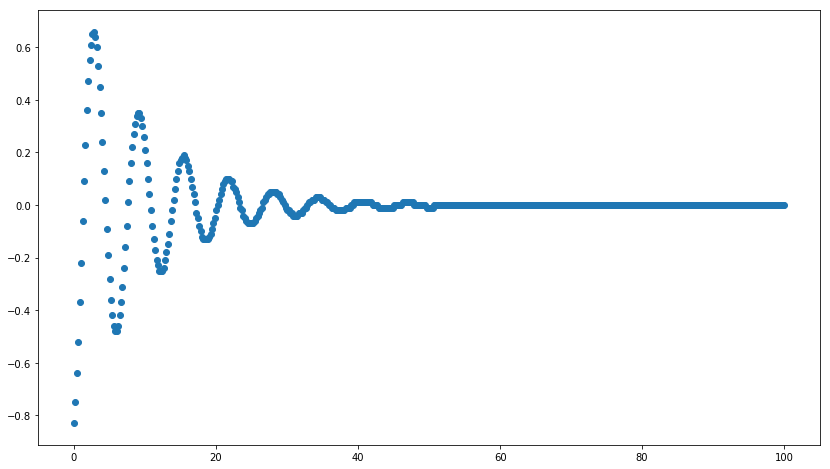

Intermediate parameters values: θ_1 = 1.0000000000000002	θ_2 = -0.8333333333333334
Regression model: y = (1.0000000000000002) * x1 + (-0.8333333333333334) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,-0.83
1,2,0,5.291508,7.252011,-0.75
2,3,0,5.363953,7.209591,-0.64
3,4,0,5.223099,6.885971,-0.52
4,5,0,4.882851,6.304896,-0.37
5,6,1,4.364393,5.499278,-0.22
6,7,1,3.695069,4.509549,-0.06
7,8,1,2.907066,3.381773,0.09
8,9,1,2.035963,2.165622,0.23
9,10,1,1.119203,0.912282,0.36


In [73]:
config = OscillationModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

## Робота алгоритму МНКО

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		436.3152068001346
alpha_1:	[0]
beta_1:		436.3152068001346
gamma_1:	-47.83270032501518
nu_1:		[-0.10962877]
> θ_1: [-0.10962877]
> H_1_inv:
[[0.00229192]]
> RSS_1: 4.135259802079119
	Step 2
h_2:		[580.96828107]
eta_2:		779.5173756995982
alpha_2:	[1.33153342]
beta_2:		[[5.93869141]]
gamma_2:	-68.64495565361116
nu_2:		[[-0.83421011]]
> θ_2: [ 1.00114988 -0.83421011]
> H_2_inv:
[[ 0.30083938 -0.22421327]
 [-0.22421327  0.16838726]]
> RSS_2: 0.002485775940422208

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.0000000000000002	θ_2 = -0.8333333333333334
Estimates:	θ_1* = 1.0011498754226396	θ_2* = -0.8342101127508632

INITIAL PARAMETERS
True values:	δ = 0.1			ω0^2 = 1.0
Estimates:	δ* = 0.09936938231450687	ω0^2* = 0.9986215997563881


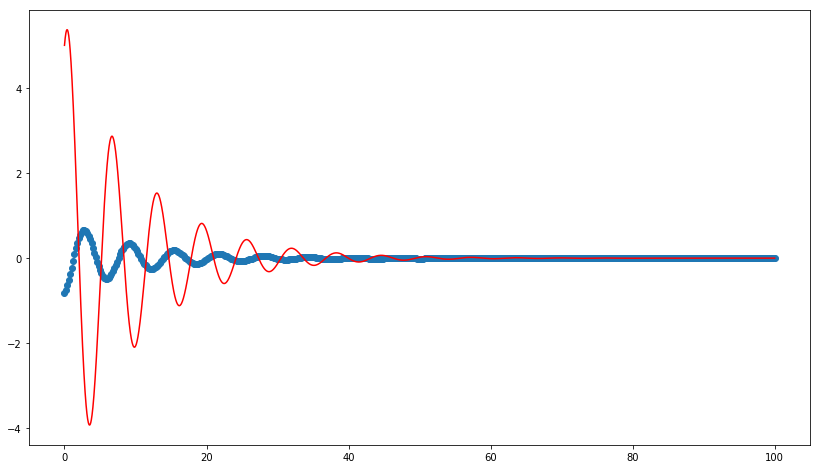

In [74]:
config.run_single_LSBM(verbose=True, deep_verbose=True)

## Таблиця залежності оцінок від рівня шуму

Розміри вибірки: [30, 80, 150]

Округлення (кількість знаків після коми) до: [0, 2, 5]

In [75]:
forward_df = config.run_grid_LSBM(verbose=False)
forward_df

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,δ,δ*,ω0_sqr,ω0_sqr*
0,0.0,30.0,1.0,1.667900,-0.833333,-1.346741,0.1,-0.128733,1.0,0.504062
1,0.0,80.0,1.0,0.892534,-0.833333,-0.731116,0.1,0.183886,1.0,1.146990
2,0.0,150.0,1.0,0.562532,-0.833333,-0.482534,0.1,0.536196,1.0,1.906606
3,2.0,30.0,1.0,1.002390,-0.833333,-0.834501,0.1,0.099160,1.0,0.997136
4,2.0,80.0,1.0,0.996119,-0.833333,-0.830388,0.1,0.102128,1.0,1.004673
5,2.0,150.0,1.0,0.999036,-0.833333,-0.832591,0.1,0.100535,1.0,1.001157
6,5.0,30.0,1.0,0.999991,-0.833333,-0.833327,0.1,0.100005,1.0,1.000010
7,5.0,80.0,1.0,0.999993,-0.833333,-0.833329,0.1,0.100003,1.0,1.000008
8,5.0,150.0,1.0,1.000000,-0.833333,-0.833334,0.1,0.100000,1.0,1.000000


Розглянемо для апроксимації центральною різницею:

$ \Rightarrow \left \{ \begin{array}{ll}
                            x(t+1)-2x(t)+x(t-1)+\delta[x(t+1)-x(t-1)]+\omega_0^2 x(t)=0 \\
                            x(0) = x_0\\
                            x(1) = x(0) + x'(0) = x_0 + x'_0
                        \end{array} \right. $

$ \iff \left \{ \begin{array}{ll}
                    x(t+2)=\frac{2-\omega_0^2}{1+\delta}x(t+1)-\frac{1-\delta}{1+\delta}x(t) \\
                    x(0) = x_0\\
                    x(1) = x_0 + x'_0
                 \end{array} \right. $

Отже, лінійна регресійна залежність виглядає таким чином:

$ \left \{ \begin{array}{ll}
                  y_i = \theta_1 x_{i1} +  \theta_2 x_{i2} + \xi_i\\
                  \theta_1 = \frac{2-\omega_0^2}{1+\delta}\\
                  \theta_2 = -\frac{1-\delta}{1+\delta}\\
                  E\xi = 0_n;\enspace cov(\xi) = \sigma^2I_n
                \end{array}
              \right. $

## Генерування вибірки

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500                with discretization frequency 6



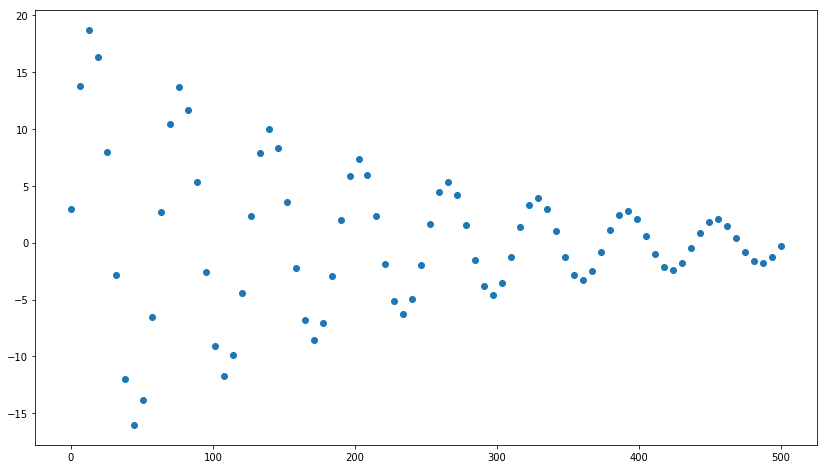

Intermediate parameters values: θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Regression model: y = (1.9800995024875623) * x1 + (-0.9900497512437811) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [41]:
config = OscillationModelConfig(difference='center')
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

## Робота алгоритму МНКО

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.2782321079894
nu_1:		[0.95801117]
> θ_1: [0.95801117]
> H_1_inv:
[[0.00028604]]
> RSS_1: 29.447942916061493
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[[30.02371322]]
gamma_2:	3428.2668093266866
nu_2:		[[-0.99035405]]
> θ_2: [ 1.98051363 -0.99035405]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]
> RSS_2: 0.0006504761413275162

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Estimates:	θ_1* = 1.9805136264573653	θ_2* = -0.9903540525860844

INITIAL PARAMETERS
True values:	δ = 0.005			ω0^2 = 0.01
Estimates:	δ* = 0.004846347513590607	ω0^2* = 0.00988811625342075


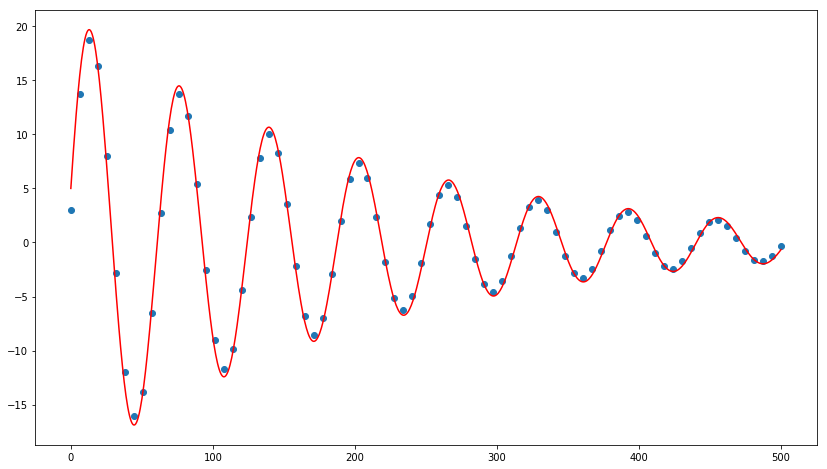

In [42]:
config.run_single_LSBM(verbose=True, deep_verbose=True)

## Таблиця залежності оцінок від рівня шуму

Розміри вибірки: [30, 80, 150]

Округлення (кількість знаків після коми) до: [0, 2, 5]

In [43]:
center_df = config.run_grid_LSBM(verbose=False)
center_df

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,δ,δ*,ω0_sqr,ω0_sqr*
0,0.0,30.0,1.9801,2.092809,-0.99005,-1.100300,0.005,-0.047755,0.01,0.007134
1,0.0,80.0,1.9801,1.959643,-0.99005,-0.966105,0.005,0.017240,0.01,0.006574
2,0.0,150.0,1.9801,1.985392,-0.99005,-0.991847,0.005,0.004093,0.01,0.006481
3,2.0,30.0,1.9801,1.980023,-0.99005,-0.989908,0.005,0.005071,0.01,0.009935
4,2.0,80.0,1.9801,1.980514,-0.99005,-0.990354,0.005,0.004846,0.01,0.009888
5,2.0,150.0,1.9801,1.979936,-0.99005,-0.989861,0.005,0.005095,0.01,0.009975
6,5.0,30.0,1.9801,1.980099,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000
7,5.0,80.0,1.9801,1.980099,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000
8,5.0,150.0,1.9801,1.980100,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000


## Об'єднана таблиця для двох видів апроксимацій

In [44]:
center_df['difference'] = 'center'
forward_df['difference'] = 'forward'
pd.concat([center_df, forward_df], axis=0).sort_values(by=['C',
                                                           'num_samples',
                                                           'difference'])

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,δ,δ*,ω0_sqr,ω0_sqr*,difference
0,0.0,30.0,1.980100,2.092809,-0.990050,-1.100300,0.005,-0.047755,0.01,0.007134,center
0,0.0,30.0,1.980198,2.092809,-0.990099,-1.100300,0.005,-0.045579,0.01,0.006809,forward
1,0.0,80.0,1.980100,1.959643,-0.990050,-0.966105,0.005,0.017240,0.01,0.006574,center
1,0.0,80.0,1.980198,1.959643,-0.990099,-0.966105,0.005,0.017542,0.01,0.006689,forward
2,0.0,150.0,1.980100,1.985392,-0.990050,-0.991847,0.005,0.004093,0.01,0.006481,center
2,0.0,150.0,1.980198,1.985392,-0.990099,-0.991847,0.005,0.004110,0.01,0.006507,forward
3,2.0,30.0,1.980100,1.980023,-0.990050,-0.989908,0.005,0.005071,0.01,0.009935,center
3,2.0,30.0,1.980198,1.980402,-0.990099,-0.990257,0.005,0.004919,0.01,0.009952,forward
4,2.0,80.0,1.980100,1.980514,-0.990050,-0.990354,0.005,0.004846,0.01,0.009888,center
4,2.0,80.0,1.980198,1.980626,-0.990099,-0.990454,0.005,0.004819,0.01,0.009922,forward


# Дослідження закономірностей селекції оптимальних моделей за різними критеріями

Розглянемо настпуні критерії

$ RSS(s) $

RSS(s) (як функція дискретного аргумента s) є строго спадною. Тобто при підвищенні складності (число аргументів або регресорів) моделі, наприклад, за рахунок шумів, значення цієї функції зменшиться. Тому її не можна використовувати в якості критерія оптимальності моделі.

Тож введемо такі два критерії, які будемо використовувати для селекції оптимальних моделей

$ C_p(s) = RSS(s) + 2s - \text{спрощений критерій Маллоуза} $

$ FPE(s) = \frac{n + s}{n - s} RSS(s) - \text{критерій фінальної помилки передбачення Акаіке} $

In [114]:
class ModelConfig():
    m = 5
    n = 100
    n_grid = [10, 30, 100]
    theta = np.array([3, -2, 1, 0, 0])
    a = 0
    b = 2
    sigma = 2
    sigma_grid = [1]
    s = 5
    s_grid = [1, 2, 3, 4, 5]
    
    def __init__(self):
        self.compile()
        
    def generate_noise_and_output(self):
        self.ksi = np.random.normal(0, self.sigma, size=self.n)
        self.y = self.X @ self.theta + self.ksi
        
    def compile(self):
        self.X = np.random.uniform(self.a, self.b, size=(self.n, self.m))
        self.generate_noise_and_output()
        
    def recompile(self, n, sigma):
        self.n = n
        self.sigma = sigma
        self.compile()
        
    def show(self):
#         print('Regressors: m = {}'.format(self.m))
#         print('True parameters: θ = {}'.format(self.theta))
        print('Sample length: n = {}'.format(self.n))
        print('Noise generation: σ = {}'.format(self.sigma))
        print('X[:10]:\n{}'.format(self.X[:10]))
        print('y[:10]:\n{}'.format(self.y[:10]))

    def run_grid_LSBM_model_selection(self):
        for i, n in enumerate(self.n_grid): 
            for j, sigma in enumerate(self.sigma_grid):
                self.recompile(n, sigma)
                print('--------------------------------------------------------------')
                print('\t\t\tSAMPLE #{}'.format(i * len(self.n_grid) + j + 1))
                print('--------------------------------------------------------------')
                print('\t\tCONFUGURATIONS & DATA')
                self.show()
                print('\n\t\tRLSM ITERATIONS')
                theta_pred, _, _, df = LSBM(self.X, self.y, s=self.s,
                                            verbose=True,
                                            create_dataframe=True)
                print('\n\t\t\tRESULTS')
                print('\nPARAMETERS')
                print('True values:\tθ: {}'.format(self.theta))
                print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
                plt.plot(df['s'], df['RSS'], label='RSS')
                plt.plot(df['s'], df['Cp'], label='Cp')
                plt.plot(df['s'], df['FPE'], label='FPE')
                plt.legend()
                plt.show()
                print(df)
                print('s* by Cp:  {}'.format(np.array(df['Cp']).argmin()+1))
                print('s* by FPE: {}'.format(np.array(df['FPE']).argmin()+1))
                print()
    
    def run_single_full_LSBM_model_selection(self,
                                             sort_values_by=['Cp', 'FPE']):
        total_df = pd.DataFrame()
        for p in permutations(range(self.X.shape[1])):
            p = np.array(p)
            theta_pred, _, _, df = LSBM(self.X[:,p], self.y, s=self.s,
                                        verbose=False, create_dataframe=True)
            df['regressors'] = [str(sorted(p[:int(s)]+1)) for s in df.s]
            total_df = pd.concat([total_df, df], axis=0)

        total_df['RSS'] = np.round(total_df['RSS'], 6)
        total_df['Cp'] = np.round(total_df['Cp'], 6)
        total_df['FPE'] = np.round(total_df['FPE'], 6)
        total_df = total_df.drop_duplicates()
        total_df = total_df.sort_values(by=sort_values_by).reset_index()\
                   [['s', 'regressors', 'RSS', 'Cp', 'FPE']]
        return total_df

## Генерування вибірки

In [ ]:
config = ModelConfig()


			RESULTS

PARAMETERS
True values:	θ: [ 3 -2  1  0  0]
Estimates:	θ*: [ 2.7407551  -2.17912069  1.32609104  0.3397386  -0.32324104]


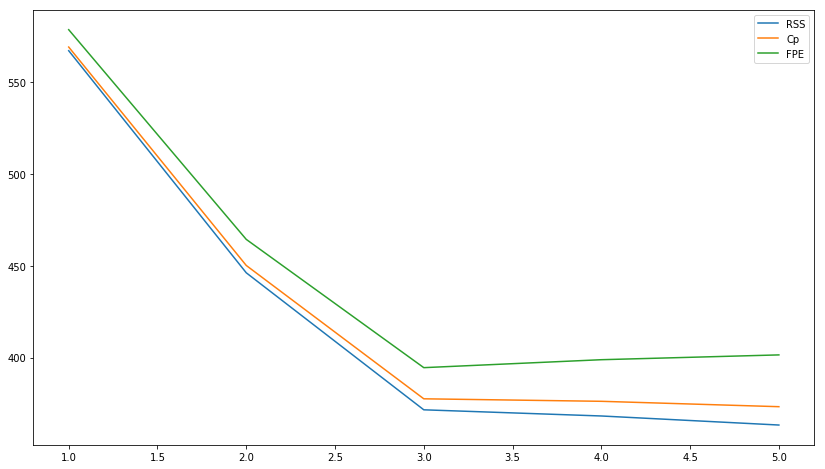

In [125]:
config.generate_noise_and_output()
# config.show()
theta_pred, _, _, df = LSBM(config.X, config.y, s=config.s,
                                            verbose=False,
                                            create_dataframe=True)
print('\n\t\t\tRESULTS')
print('\nPARAMETERS')
print('True values:\tθ: {}'.format(config.theta))
print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
plt.plot(df['s'], df['RSS'], label='RSS')
plt.plot(df['s'], df['Cp'], label='Cp')
plt.plot(df['s'], df['FPE'], label='FPE')
plt.legend()
plt.show()

## Результати роботи МНКО для кожної складності моделі

Розміри вибірки:  [10, 30, 100]

Дисперсії: [0.1, 0.5, 1]

--------------------------------------------------------------
			SAMPLE #1
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.0
X[:10]:
[[1.99706681 1.00643602 0.89425756 1.16897959 0.09889183]
 [1.39407754 0.3464595  1.87934508 0.60915648 1.26335218]
 [0.8792504  0.68010345 1.35758337 0.79367044 1.15005723]
 [0.29488956 0.48162994 1.54238188 0.43959912 1.6090795 ]
 [1.52755931 1.77458278 1.31479298 1.27223615 0.66931476]
 [0.7061045  1.82104582 1.09436243 0.63756769 0.89346922]
 [1.96696585 1.55128914 1.39907878 1.1426578  1.80293419]
 [1.26869551 0.50726934 0.93861668 0.25166521 0.15481954]
 [1.93698584 1.71109588 0.34339105 0.86957001 0.55629629]
 [1.48433092 0.02508538 1.91073426 1.3275312  0.02754341]]
y[:10]:
[ 4.87258593  5.36865869  2.63512766  1.46379068  2.34830535 -0.42941572
  4.19739805  3.73016454  2.73215681  6.31355625]

		RLSM ITERATIONS
	Step 1
> θ_1: [2.41718796]
> H_1_inv:
[[0.0474890

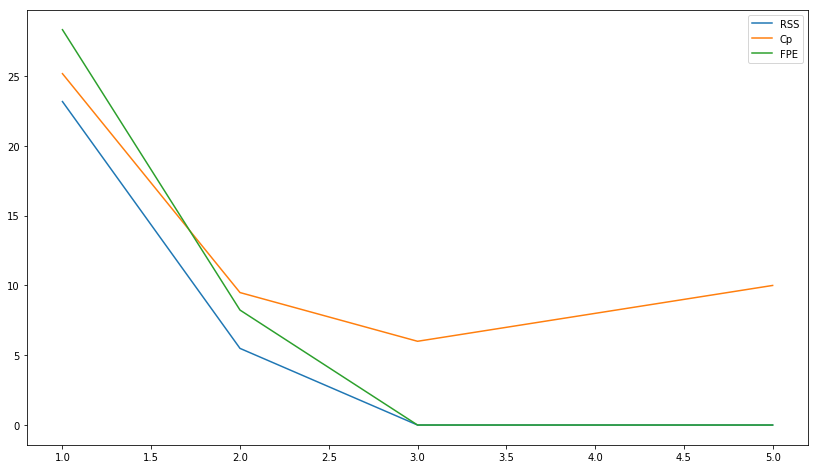

     s           RSS         Cp           FPE
0  1.0  2.317343e+01  25.173431  2.832308e+01
1  2.0  5.490801e+00   9.490801  8.236202e+00
2  3.0  2.664535e-14   6.000000  4.948423e-14
3  4.0  2.664535e-14   8.000000  6.217249e-14
4  5.0  2.664535e-14  10.000000  7.993606e-14
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #2
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.5
X[:10]:
[[0.22753025 0.62132799 1.91682943 0.79697481 0.45597183]
 [0.36767179 1.3707943  1.88926944 1.2187003  0.61498114]
 [0.89740101 0.19444508 0.08702312 1.43419757 1.94881959]
 [0.85534292 1.22089787 0.06090608 0.99809596 0.64247857]
 [1.97534301 0.17580876 1.12466067 0.6592879  0.22061759]
 [1.47418614 0.54286338 0.05416176 0.47374255 1.30439362]
 [1.7960941  1.66503733 0.41687705 0.43928523 0.95919346]
 [1.89509774 1.60295402 1.46442833 1.6349866  1.59160289]
 [1.65532229 1

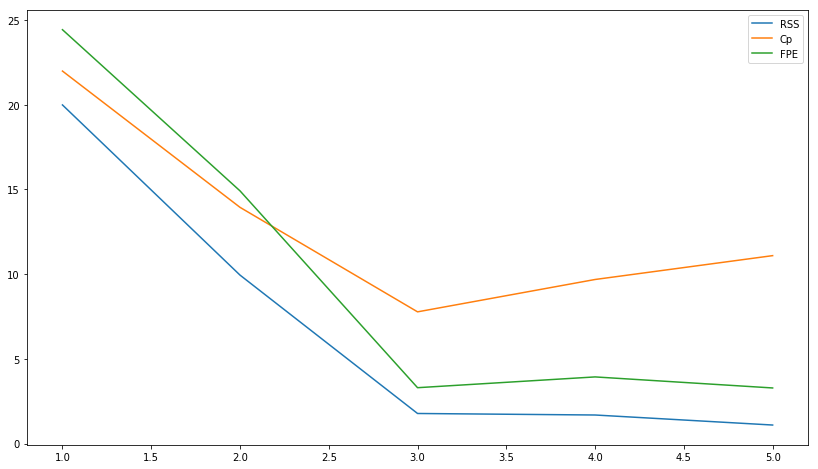

     s        RSS         Cp        FPE
0  1.0  19.990400  21.990400  24.432711
1  2.0   9.945467  13.945467  14.918200
2  3.0   1.776026   7.776026   3.298335
3  4.0   1.686280   9.686280   3.934653
4  5.0   1.094273  11.094273   3.282819
s* by Cp:  3
s* by FPE: 5

--------------------------------------------------------------
			SAMPLE #3
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 1
X[:10]:
[[0.7086092  1.25572636 1.82341961 1.80203596 1.22170216]
 [0.91697415 1.71921053 1.81161052 0.80447054 0.10364897]
 [0.9815182  0.3480004  0.05764109 0.65043028 1.90722219]
 [1.88296973 0.78462185 0.19704598 0.09108322 0.43531295]
 [1.19274693 0.63433376 1.36906576 0.09751986 0.17430894]
 [1.22006413 0.05629184 0.31422687 0.03314114 1.42754017]
 [0.86769119 0.43218529 1.76458396 0.19922585 0.83022289]
 [0.14498534 0.65458576 0.48084575 1.00189633 1.5107815 ]
 [0.16171535 0.01009505 0.17131498 0.24638918 1.5749

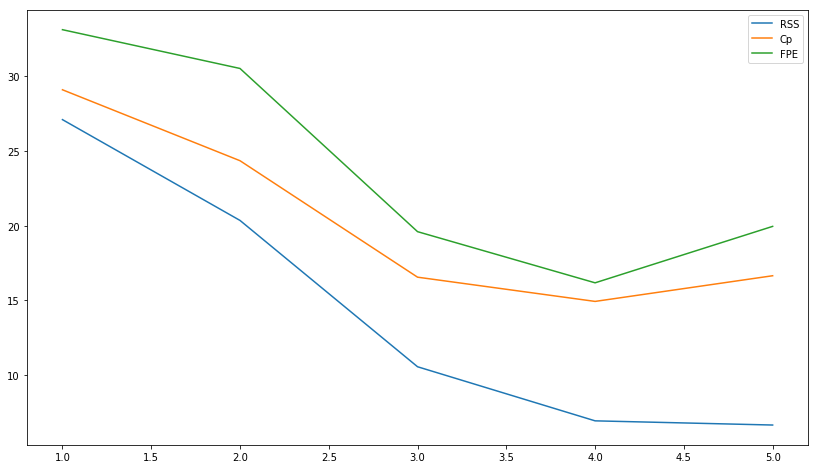

     s        RSS         Cp        FPE
0  1.0  27.110072  29.110072  33.134533
1  2.0  20.357900  24.357900  30.536850
2  3.0  10.556870  16.556870  19.605615
3  4.0   6.933779  14.933779  16.178817
4  5.0   6.653154  16.653154  19.959461
s* by Cp:  4
s* by FPE: 4

--------------------------------------------------------------
			SAMPLE #4
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.0
X[:10]:
[[1.56473763 0.92966328 1.20219186 0.40528939 1.49546627]
 [0.96007376 1.76656576 0.3498373  1.97340443 1.10736159]
 [0.63839309 0.58479226 0.58409203 1.83259206 0.86628922]
 [1.98234564 1.95001449 0.13672076 1.23560051 0.2085462 ]
 [1.57792576 0.17622557 1.89834403 0.78902484 0.15083711]
 [1.48295597 0.84698607 0.52652992 0.29471037 0.40206805]
 [1.79965471 0.67137375 0.05146653 0.81811492 0.75525381]
 [0.24599837 1.77476394 1.42663531 1.38872401 0.64951637]
 [1.15240736 0.20581051 1.31404581 0.57547368 1.63

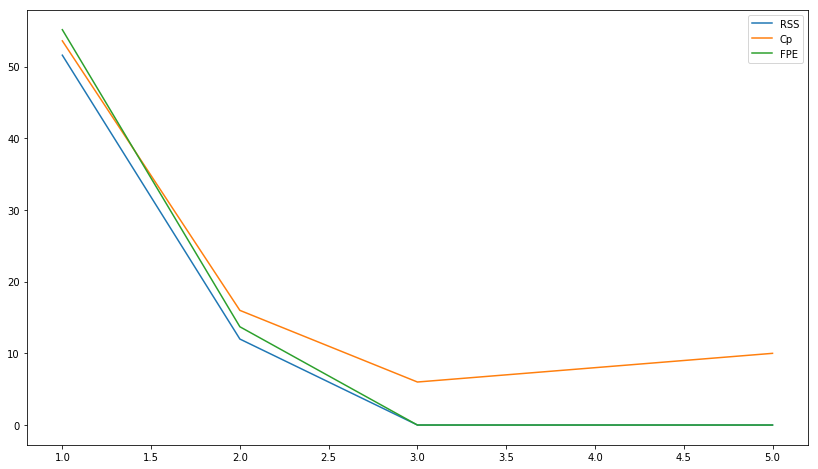

     s           RSS         Cp           FPE
0  1.0  5.158558e+01  53.585583  5.514321e+01
1  2.0  1.199360e+01  15.993598  1.370697e+01
2  3.0 -7.283063e-14   6.000000 -8.901521e-14
3  4.0 -7.283063e-14   8.000000 -9.524006e-14
4  5.0 -7.283063e-14  10.000000 -1.019629e-13
s* by Cp:  3
s* by FPE: 5

--------------------------------------------------------------
			SAMPLE #5
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.5
X[:10]:
[[0.88868136 1.07462309 0.70631689 1.76215021 1.89895528]
 [1.33965396 0.95266523 0.60870287 1.75228631 1.14812203]
 [0.71263543 1.35459709 0.49788928 1.12054401 0.77564685]
 [0.83259166 0.3829404  1.460208   0.37459593 1.75837823]
 [1.63716095 0.0952512  0.71084825 0.69965207 0.66197542]
 [0.27562393 1.64491473 1.35293612 1.18557032 0.50875359]
 [0.42679374 0.19271576 0.0575435  1.68491105 0.79080811]
 [0.91980886 0.73644108 0.53653749 1.26573134 0.43666723]
 [0.72333517 1

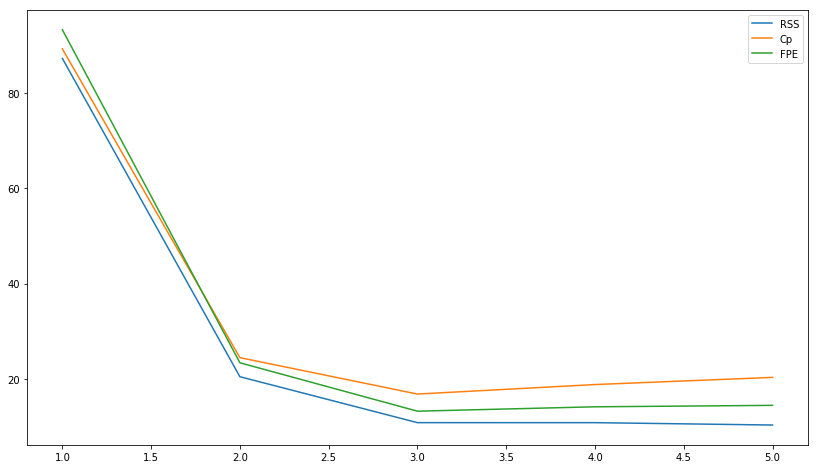

     s        RSS         Cp        FPE
0  1.0  87.287757  89.287757  93.307603
1  2.0  20.469457  24.469457  23.393666
2  3.0  10.826473  16.826473  13.232355
3  4.0  10.822089  18.822089  14.151962
4  5.0  10.325233  20.325233  14.455326
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #6
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 1
X[:10]:
[[1.80770259 0.78824887 0.9003233  1.74011452 0.60504781]
 [1.44810522 0.84750807 0.77837563 0.14037299 1.09712467]
 [1.3465808  1.83078967 1.09930189 1.49073057 0.1417211 ]
 [0.12689215 1.6621961  0.28061751 0.91877396 0.53610434]
 [0.28160148 1.03104727 1.78427334 1.32659525 1.61045246]
 [0.42631852 0.3229225  1.05739834 1.0581075  0.58142493]
 [1.93533668 0.40972976 1.59257773 0.25306597 0.23884042]
 [1.03498334 1.10061557 0.45768074 1.87037003 0.68004716]
 [0.75267849 1.43715854 1.64150123 0.21010923 0.9077

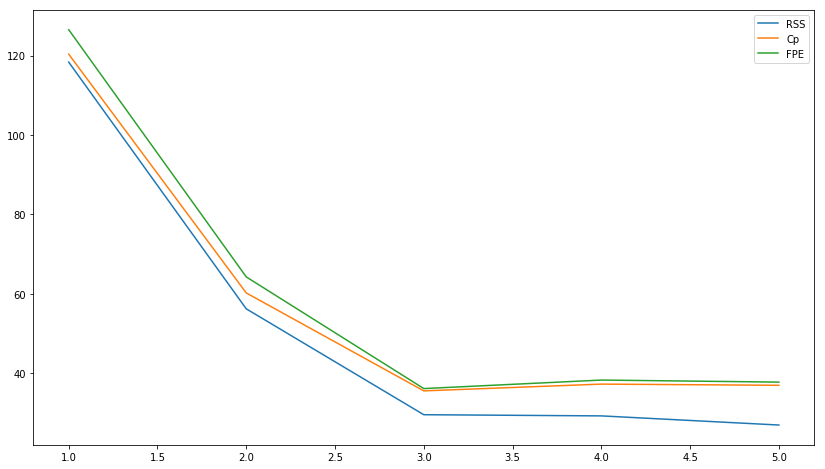

     s         RSS          Cp         FPE
0  1.0  118.352764  120.352764  126.515024
1  2.0   56.255369   60.255369   64.291851
2  3.0   29.606455   35.606455   36.185667
3  4.0   29.309421   37.309421   38.327705
4  5.0   27.008911   37.008911   37.812475
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #7
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.0
X[:10]:
[[0.35829806 1.64961664 0.94574176 1.46171302 1.14964113]
 [1.51376731 1.11036552 1.83842073 0.09428238 1.77696947]
 [0.78670994 0.5985219  0.96458875 0.43811746 1.9233941 ]
 [1.45092005 1.07695095 1.01210005 0.80565704 1.71655944]
 [0.80181484 1.86220715 0.12798377 1.52558357 0.09105259]
 [0.20300692 1.40946916 0.38174314 1.46135822 0.51917143]
 [1.15616896 0.46954735 0.7923136  0.94272155 1.32770768]
 [0.92870781 0.05219734 0.53553606 1.56590375 0.69294663]
 [1.96541223 0.77709252 0.18001

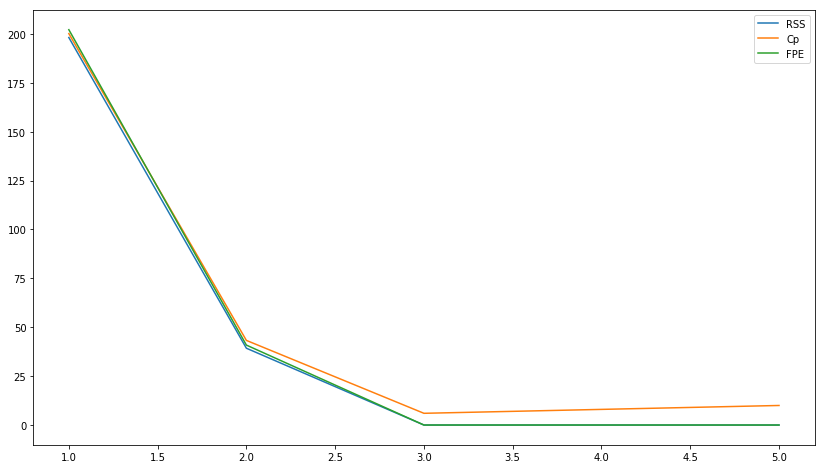

     s           RSS          Cp           FPE
0  1.0  1.981838e+02  200.183793  2.021875e+02
1  2.0  3.928478e+01   43.284784  4.088824e+01
2  3.0 -7.815970e-13    6.000000 -8.299432e-13
3  4.0 -7.815970e-13    8.000000 -8.467301e-13
4  5.0 -7.815970e-13   10.000000 -8.638704e-13
s* by Cp:  3
s* by FPE: 5

--------------------------------------------------------------
			SAMPLE #8
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.5
X[:10]:
[[1.34350952 1.72778916 0.82527088 0.89605449 1.53016198]
 [0.65858144 0.61214679 1.90776757 0.90381975 1.53436904]
 [1.14161393 1.92266661 1.33541046 1.69585911 1.1696866 ]
 [0.1711359  1.27816728 0.88323005 0.32689725 0.5375432 ]
 [1.30243848 1.33620605 0.29805327 0.18596897 1.23247997]
 [1.05864978 1.68362345 0.11203034 1.58829462 1.00993025]
 [1.43652767 1.09637316 1.37797885 1.21223564 0.16925066]
 [0.92810003 0.70088532 1.21122935 1.33272537 0.16300282]
 [0.571

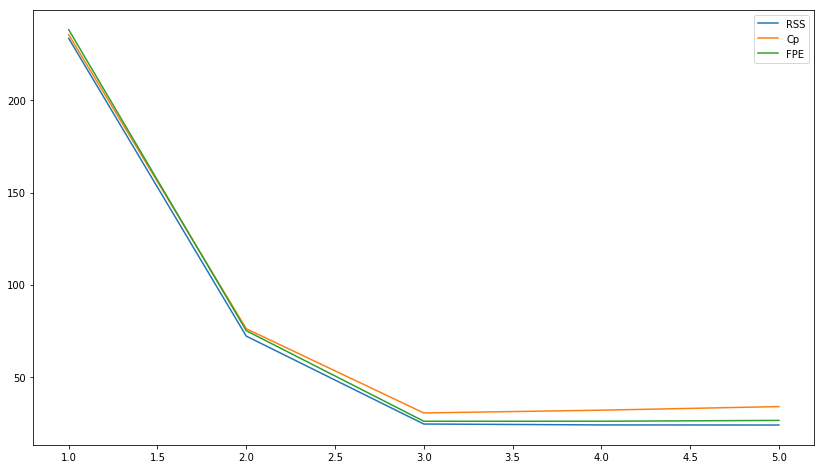

     s         RSS          Cp         FPE
0  1.0  233.638363  235.638363  238.358330
1  2.0   72.113809   76.113809   75.057230
2  3.0   24.416899   30.416899   25.927222
3  4.0   23.928144   31.928144   25.922156
4  5.0   23.869691   33.869691   26.382290
s* by Cp:  3
s* by FPE: 4

--------------------------------------------------------------
			SAMPLE #9
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 1
X[:10]:
[[1.17393419 1.57391308 0.30261218 0.68360586 0.39749251]
 [1.02773252 0.96933487 0.93948142 0.38295745 1.01174915]
 [1.74559199 0.73140139 1.11564121 0.38713377 0.0467273 ]
 [1.33083804 1.43148267 1.30053024 0.15454036 0.2778561 ]
 [1.81972516 1.8098719  0.52882891 1.1389582  1.26463686]
 [1.43514633 0.48385624 1.83111327 1.86083779 0.09160034]
 [0.62747188 1.41573745 1.42283747 0.65898053 0.79935844]
 [1.59223328 0.85354309 1.15082185 0.01510072 0.31813943]
 [0.68844945 0.63585972 0.2050235

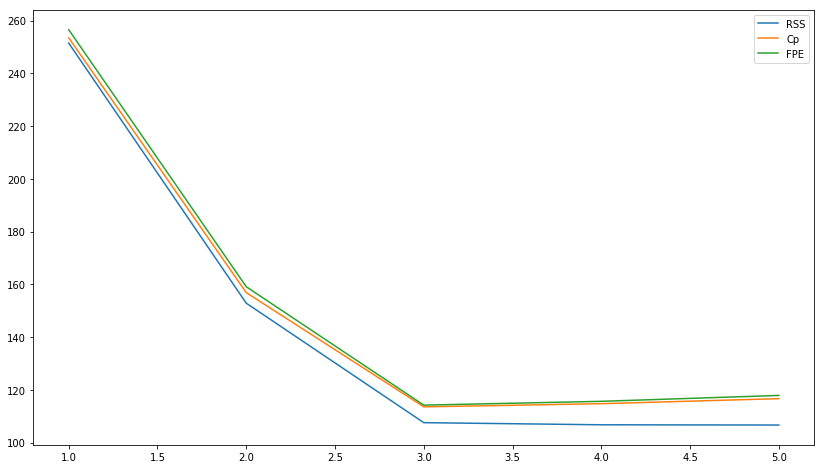

     s         RSS          Cp         FPE
0  1.0  251.453194  253.453194  256.533057
1  2.0  152.837038  156.837038  159.075284
2  3.0  107.535235  113.535235  114.186899
3  4.0  106.735488  114.735488  115.630112
4  5.0  106.639566  116.639566  117.864783
s* by Cp:  3
s* by FPE: 3



In [80]:
config.run_grid_LSBM_model_selection()

## Результати роботи МНКО для кожної складності моделі з перестановками

Оскільки алгоритм МНКО діє послідовно в порядку розташування регресорів, має сенс будувати моделі для перестановок (найвпливовіший регресор, наприклад, може бути розташований в кінці, а найменш впливовий - на початку; це потрібно відслідковувати).

Тож виконаємо МНКО для однієї вибірки довжини n = 100, з дисперсією шуму $\sigma$ = 0.01 з перестановкою регресорів.

In [59]:
config.recompile(100, 0.01)
config.show()
config.run_single_full_LSBM_model_selection(sort_values_by=['Cp', 'FPE'])
# ['s', 'Cp', 'FPE']

Sample length: n = 100
Noise generation: σ = 0.01
X[:10]:
[[1.43734787 0.64380797 1.9331151  1.22393953 0.57541593]
 [0.43288643 1.16300783 1.05530523 1.91089315 0.67563202]
 [0.79789082 1.5146693  1.79452849 1.9469083  0.36814956]
 [1.87585534 1.55861975 0.18163053 1.97537512 1.54758054]
 [0.79033379 1.65509606 1.8795907  1.97841836 1.4549698 ]
 [1.82835583 1.57805979 1.48477723 1.20968024 0.63915251]
 [1.1033401  0.29208596 0.94685849 1.2939826  0.74519581]
 [1.43562065 0.15427611 0.45678931 1.01181888 0.68518061]
 [1.56277042 1.69063449 1.95164368 0.9354009  1.72344224]
 [0.90084667 0.53170403 1.80046023 1.86392958 1.53619873]]
y[:10]:
[4.94886317 0.01665568 1.16020803 2.6970036  0.94619919 3.80335882
 3.67895889 4.45931682 3.24581683 3.42332431]


,s,regressors,RSS,Cp,FPE
0,3.0,"[1, 2, 3]",0.010967,6.010967,0.011645
1,4.0,"[1, 2, 3, 4]",0.010935,8.010935,0.011846
2,4.0,"[1, 2, 3, 5]",0.010948,8.010948,0.011860
3,5.0,"[1, 2, 3, 4, 5]",0.010922,10.010922,0.012072
4,4.0,"[1, 2, 4, 5]",46.552954,54.552954,50.432367
5,3.0,"[1, 2, 4]",48.679096,54.679096,51.690174
6,3.0,"[1, 2, 5]",51.211384,57.211384,54.379098
7,2.0,"[1, 2]",55.143774,59.143774,57.394541
8,4.0,"[1, 3, 4, 5]",138.271856,146.271856,149.794510
9,3.0,"[1, 3, 4]",149.784275,155.784275,159.049282


В даному випадку за другим критерієм оптимальною є модель складності 3 з регресорами 1, 2, 3. 

# Висновки

При побудові регресійних моделей для різницевого рівняння моделі Фергюльста та різницевого рівнянна згасаючих коливань ми показали, що алгоритм МНКО є ефективним при оцінюванні параметрів моделі. У порівнянні з МНК він є набагато менш затратним через те, що не виконує пряме обертання матриці, а рекурентно виконує апроксимацію оберненої матриці, і при цьому дає досить точні оцінки, залежність точності яких від шуму була показана в роботі. При відносно невеликих шумах алгоритм показує дуже хороші результати.
В ході проведення статистичних експериментів ми з'ясували, що критерії Маллоуза і критерій фінальної помилки передбачення Акаіке є досить стійкими до зростаючого рівня шуму, і при додаванні нерелевантних регресорів моделі, вони не обирають переускладнені моделі, оскільки в них наявний штраф за складність. За теоретичними оцінками відомо, що за умови наявності точної оцінки дисперсії (рівня) шуму критерій Маллоуза є оптимальним з точки зору теорії завадостійкого моделювання. Ми підтвердили це експериментально.